# Binary classification of RGB images of "Rock, Paper, Scissors" hand signs

## Reproducible notebooks

1. The very first time you create the notebook, do so in a new directory. Create the notebook and the very first time only, include the lines

    ```julia
    using Pkg
    Pkg.activate(".")
    push!(empty!(Base.LOAD_PATH), "@stdlib", pwd())
    Pkg.instantiate()
    ```
    -

2. Now add the packages you want to add, e.g., `Pkg.add("Plots")` and so on. This will add these packages to the `Project.toml` and `Manifest.toml` files. You will know that you have done Step 1 correctly if the `Project.toml` and `Manifest.toml` files appear in the directory and you see that they have been updated. If you don’t see them, it means they are in some other directory so you will have to make sure you are creating the notebook in the directory and then doing Step 1.

3. After you have added all the packages, do

    ```julia
    Pkg.instantiate()
    ```

    This will install the packages. Now you can use the package via the `using` command as before.

4. Copy/paste your code after and make sure that the notebook runs.

5. Comment out the lines in 1) and 2) and send the .ipynb notebook along with the Project.toml and the Manifest.toml file and any data (including the .jl files) used by your notebook to your collaborators. This is how we make this a reproducible notebook.

https://docs.google.com/document/d/11aaUc1pkb2atTjeATBQmLLlb7NwLZXN8nzqQYHcSG6c/edit

## Initialization

### Install packages

In [18]:
# Run this only once
using Pkg
Pkg.activate(".")
push!(empty!(Base.LOAD_PATH), "@stdlib", pwd())
Pkg.add("IJulia")
Pkg.add("ImageIO")
Pkg.add("ImageMagick")
Pkg.add("Plots")
Pkg.add("Images")
Pkg.add("Interact")
Pkg.add("JLD2")
Pkg.instantiate()

 Activating environment at `~/dev/Continuum-ML-F20/BinaryClassificationRGB/Project.toml`
  Resolving package versions...
No Changes to `~/dev/Continuum-ML-F20/BinaryClassificationRGB/Project.toml`
No Changes to `~/dev/Continuum-ML-F20/BinaryClassificationRGB/Manifest.toml`
  Resolving package versions...
Updating `~/dev/Continuum-ML-F20/BinaryClassificationRGB/Project.toml`
  [82e4d734] + ImageIO v0.3.0
Updating `~/dev/Continuum-ML-F20/BinaryClassificationRGB/Manifest.toml`
  [fa961155] + CEnum v0.4.1
  [82e4d734] + ImageIO v0.3.0
  [f57f5aa1] + PNGFiles v0.3.1
  [b53b4c65] + libpng_jll v1.6.37+5
  Resolving package versions...
Updating `~/dev/Continuum-ML-F20/BinaryClassificationRGB/Project.toml`
  [6218d12a] + ImageMagick v1.1.6
Updating `~/dev/Continuum-ML-F20/BinaryClassificationRGB/Manifest.toml`
  [6218d12a] + ImageMagick v1.1.6
  [c73af94c] + ImageMagick_jll v6.9.10-12+3
  [aacddb02] + JpegTurbo_jll v2.0.1+2
  [89763e89] + Libtiff_jll v4.1.0+1
  [3161d3a3] + Zstd_jll v1.4.5+1
  

### Import modules

In [19]:
using Plots, Images, Interact, JLD2
using Random: randperm, seed!

theme(
    :wong;
    label="",
    markerstrokewidth=0.3,
    markerstrokecolor=:white
)

In [20]:
# Run this only once
include("MyLearn2Classify.jl")
using Main.MyLearn2Classify

### Load Data

In [21]:
X_rock = load("data/rock.jld2")["rock_imgs"]
X_paper = load("data/paper.jld2")["paper_imgs"]
X_scissors = load("data/scissors.jld2")["scissors_imgs"];

## Functions

In [22]:
"""
    img = array2rgb(X)

Given a `height` x `width` x `3` array, return an RGB image with the same
dimensions, where

    img[i, j] = RGB(X[i, j, 1], X[i, j, 2], X[i, j, 3])
"""
function array2rgb(X::Array{T, 3}) where T <: Number
    height, width = size(X, 1), size(X, 2)
    img = Array{RGB, 2}(undef, height, width)
    
    for i in 1:height, j in 1:width
        r, g, b = X[i, j, :]
        img[i, j] = RGB(r, g, b)
    end
    return img
end

"""
    Y = array2matrix(X)

Given a four-dimensional array `X`, vectorize each slice of `X` along
its fourth dimension. For example, if `X` has size `height` x `width` x
`rgb` x `n_samples`, then the returned matrix has size
`height * width * rgb` x `n_samples`.
"""
function array2matrix(X::AbstractArray{T, 4}) where T
    height, width, rgb, n_samples = size(X)

    Y = zeros(height * width * rgb, n_samples)

    for idx in 1:n_samples
        Y[:, idx] = vec(X[:, :, :, idx])
    end

    return Y
end

"""
    Y = array2matrix(X, slice_dim)

Given an array `X`, vectorize each slice of `X` along dimension `slice_dim`.

This function is useful for converting high-dimensional datasets with a
sample dimension into data matrices for training neural networks.
"""
function array2matrix(X::AbstractArray, slice_dim::Integer)
    return hcat((vec(slice) for slice in eachslice(X; dims=slice_dim))...)
end

"""
    X_train, X_test = split_train_test(X, train_fraction[, sample_dim]; seed=1)

Split an array `X` along dimension `sample_dim` into `X_train` and `X_test`, where
`X_train` contains a random fraction `train_fraction` (where `train_fraction` is
between 0 and 1) of the samples, and `X_test` contains the remaining samples.

Notes:
- `sample_dim` is set to the last dimension of `X` by default.
- The `seed` keyword argument (default: 1) may be set to keep `X_train` and `X_test` the same across multiple runs.
"""
function split_train_test(X::AbstractArray, train_fraction::Float64, sample_dim::Int64=ndims(X); seed::Integer=1)
    n_samples = size(X, sample_dim)
    n_train = round(Integer, n_samples * train_fraction)

    train_idx = randperm(seed!(seed), n_train)
    test_idx = setdiff(1:n_samples, train_idx)

    X_train = selectdim(X, sample_dim, train_idx)
    X_test = selectdim(X, sample_dim, test_idx)

    return X_train, X_test
end

shared_fraction(v1, v2) = sum(v1 .== v2) / length(v1)

function compute_pcorrect(X::AbstractMatrix, y::Vector, w::Vector, b::Float64, f_a::Function)
    network_output = gn(X, w, b, f_a)
    class1_encoding = 0
    class2_encoding = 1
    threshold = 0.5
    y_out = [x < threshold ? class1_encoding : class2_encoding for x in network_output]

    return shared_fraction(y, y_out)
end;

## Reshape Data

In [23]:
X_rock_vec = array2matrix(X_rock)
X_paper_vec = array2matrix(X_paper)

train_fraction = 0.6
X_rock_train, X_rock_test = split_train_test(X_rock_vec, train_fraction)
X_paper_train, X_paper_test = split_train_test(X_paper_vec, train_fraction)

X_train = [X_rock_train X_paper_train]
X_test = [X_rock_test X_paper_test]

y_train = [zeros(size(X_rock_train, 2)); ones(size(X_paper_train, 2))]
y_test = [zeros(size(X_rock_test, 2)); ones(size(X_paper_test, 2))];

## Train

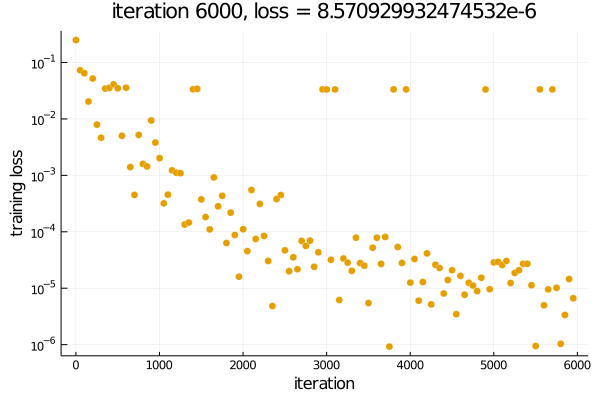

In [24]:
f_a = sigmoid # in [sigmoid, linear, tanh]
df_a = dsigmoid # in [dsigmoid, linear, dtanh]
mu = 0.01
iters = 6000
batch_size = 30
show_loss = true
normalize = true
seed = false

w_hat, b_hat, loss = learn2classify_asgd(
    f_a,
    df_a,
    grad_loss,
    X_train,
    y_train,
    mu,
    iters,
    batch_size,
    show_loss,
    normalize,
    seed
);

## Review

In [25]:
println("Training pcorrect: $(compute_pcorrect(X_train, y_train, w_hat, b_hat, f_a))")
println("Testing pcorrect: $(compute_pcorrect(X_test, y_test, w_hat, b_hat, f_a))")

Training pcorrect: 0.9976525821596244
Testing pcorrect: 0.9366197183098591


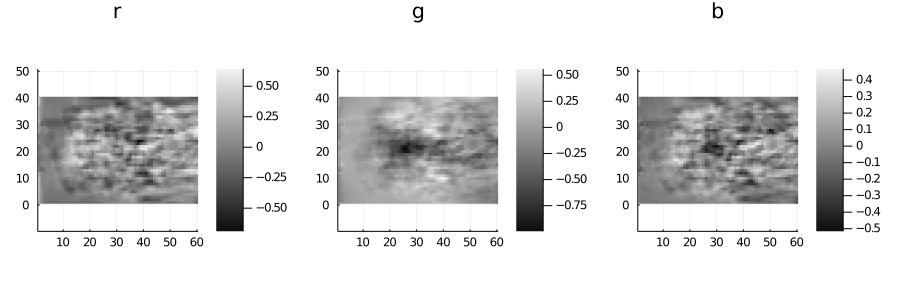

In [26]:
h, w, rgb, n_samples = size(X_rock)
w_hat_rgb = reshape(w_hat, h, w, rgb)

plot(
    heatmap(w_hat_rgb[:, :, 1], color=:grays, title="r", aspect_ratio=1.0),
    heatmap(w_hat_rgb[:, :, 2], color=:grays, title="g", aspect_ratio=1.0),
    heatmap(w_hat_rgb[:, :, 3], color=:grays, title="b", aspect_ratio=1.0),
    layout=(1, 3),
    size=(900, 300)
)

In [27]:
incorrect_idx(y::Vector, y_true::Vector) = findall(y .!= y_true)
network_output = gn(X_test, w_hat, b_hat, f_a)
y_out = [x < 0.5 ? 0.0 : 1.0 for x in network_output]

output2label = Dict(0.0 => "Rock", 1.0 => "Paper")
println("Incorrectly classified")
@manipulate throttle=0.3 for idx in incorrect_idx(y_out, y_test)
    X = reshape(X_test[:, idx], h, w, rgb)
    
    array2rgb(X)
end

Incorrectly classified
┌ Info: Precompiling PNGFiles [f57f5aa1-a3ce-4bc8-8ab9-96f992907883]
└ @ Base loading.jl:1278
┌ Info: Precompiling ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1278


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["idx"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 36,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
18, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/jimmy/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/jimmy/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/jimmy/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/home/jimmy/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/home/jimmy/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe467608280, Task (runnable) @0x00007fe467608280), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"22\",\"37\",\"54\",\"56\",\"89\",\"97\",\"147\",\"166\",\"170\",\"183\",\"193\",\"221\",\"233\",\"261\",\"305\",\"325\",\"327\",\"332\",\"353\",\"377\",\"384\",\"406\",\"409\",\"412\",\"414\",\"434\",\"437\",\"453\",\"458\",\"467\",\"478\",\"518\",\"5